In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

plt.style.use("dark_background")

df = pd.read_csv("./tour_logs_train.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gig_ID                 2000 non-null   object 
 1   Venue_ID               2000 non-null   object 
 2   Show_DateTime          2000 non-null   object 
 3   Day_of_Week            2000 non-null   int64  
 4   Volume_Level           1819 non-null   float64
 5   Ticket_Price           2000 non-null   object 
 6   Crowd_Size             1960 non-null   float64
 7   Opener_Rating          2000 non-null   int64  
 8   Weather                2000 non-null   object 
 9   Moon_Phase             2000 non-null   object 
 10  Band_Outfit            2000 non-null   object 
 11  Merch_Sales_Post_Show  2000 non-null   int64  
 12  Crowd_Energy           2000 non-null   float64
dtypes: float64(3), int64(3), object(7)
memory usage: 203.3+ KB
None


summary of notes

1) Testing whether Tuesday causes crowd energy to drop significatly
2) Testing : Some venue has a noise limit i.e crowd energy drops for high noise at this venue
3) Testing : If crowd energy drops when there are too many people
4) Testing : If night time has higher change of higher crowd energy
5) Testing : If full moon the crowd goes insane
6) Testing : Does combination of venue and clothes matter
7) Testing : Wheather weather (haha pun) matters , especially does it matter more for outdoor venus (V_Delta)
8) Testing : Prics and Venue combination matters for crowd energy
9) Filtering : Adjusting prices in USD
10) Filtering : Making sure prices are between 0 and 100 dollars
11) Testing : If volume, time, price, crowd_size  matters
12) Testing : Opener, outfit, Sock color matters or not
13) Testing : V_Delta and crowd size and volume correlation
14) Filtering : Energy scores must be between 0-100
15) Filtering : Crowd count must be between 0-1000
16) Filtering : remove negative values
17) Finding : Ticket price for each venue to maximise profit , cost $5,000 + $8 * crowd_size , and crowd_size is < 800>
18) Testing : Ticket price depends on outfit or not 
19) Testing : Weekends and crowd enery relation
20) Filtering : Fix NaN values for Volume , Volume goes from 1-11, NaN or 0 most likely mean volume = 11 , (pushing too hard = max volume)
21) 1. "Volume matters" vs "Crowd size matters more"
   → Maybe both? Maybe it depends on venue?

2. "Weekends are always better" vs "That Tuesday in London was fire"
   → Are weekends USUALLY better or ALWAYS better?

3. "Price sensitivity is at V_Gamma" vs "I remember a pricing thing at V_Delta"
   → Who actually cares about price? Everyone? Just snobs?

4. "Timing matters for goths" vs "Every venue has timing preferences"
   → Is V_Beta special or am I generalizing?

5. "outfit phase is real" vs "The drummer says I'm crazy"
   → VERIFY THIS. Prove him wrong.

6. "Weather affects energy" vs "Weather affects MY mood"
   → Control for my mood somehow? Oh wait, you can't. Never mind.



### ***STEP 1: Fill NaN values one by one***

In [2]:
df.isna().sum()

Gig_ID                     0
Venue_ID                   0
Show_DateTime              0
Day_of_Week                0
Volume_Level             181
Ticket_Price               0
Crowd_Size                40
Opener_Rating              0
Weather                    0
Moon_Phase                 0
Band_Outfit                0
Merch_Sales_Post_Show      0
Crowd_Energy               0
dtype: int64

# 1 Volume_Level

In [3]:
df.Volume_Level.describe()

count    1819.000000
mean        5.637163
std         5.508995
min        -5.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        99.000000
Name: Volume_Level, dtype: float64

as per the singers notes (20) , volume is between 1-11 (both inclusive)

i.e
Replace all values apart from [1, 11] to 11 as singer said that the system glitches when he pushes it oo haed , therefore we replace it with the median

In [4]:

good = df[(df["Volume_Level"] >= 1) & (df["Volume_Level"] <= 11)]
medians = good.groupby("Venue_ID")["Volume_Level"].median()

bad = (df["Volume_Level"] <= 0) | (df["Volume_Level"] > 11) | (df["Volume_Level"].isna())

df.loc[bad, "Volume_Level"] = df.loc[bad, "Venue_ID"].map(medians)


print(df.isna().sum())

Gig_ID                    0
Venue_ID                  0
Show_DateTime             0
Day_of_Week               0
Volume_Level              0
Ticket_Price              0
Crowd_Size               40
Opener_Rating             0
Weather                   0
Moon_Phase                0
Band_Outfit               0
Merch_Sales_Post_Show     0
Crowd_Energy              0
dtype: int64


# 2 Merch_Sales_Post_Show

we must drop this column immidietly as it is a data after consert has ended

In [5]:
merch = df["Merch_Sales_Post_Show"] # copy to use afterwards

In [6]:
df.drop(columns=["Merch_Sales_Post_Show"], inplace=True)

# 3 Show_Date_Time

since this data contains many different patters of datetime we use pandas inbuilt date time extractor and covert this raw string into
`Hour`
`Day_Of_Month`
`Day_Of_Week`
`Month`

In [7]:
# first let's see how many distict patters are there in our dataset
def identifying_patterns(date):
    date = str(date)
    # now to identify pattern of that date we replace all the numbers with 0 and all the letters with A
    pattern = re.sub(r"\d", '0', re.sub(r"[a-zA-Z]", "A", date))
    # the third argument above retuns all lettrs replased with A and the outside fuction returns all numbers replaced with 0 
    return pattern

# apply the above function to datetime colum and see the results
result = df["Show_DateTime"].apply(identifying_patterns)

print(df.groupby(result)["Show_DateTime"].first())
print("\n")
print(df.groupby(result).size())

Show_DateTime
00-00-0000 00:00          04-27-2024 20:00
00/00/0000 00:00 AA    08/07/2024 08:00 AM
0000-00-00 00:00:00    2024-03-07 21:00:00
AAA 00, 0000                  May 17, 2024
AAAA 00, 0000                June 04, 2024
AAAA AAAAA                      Late Night
AAAAA 00, 0000              April 07, 2024
AAAAAA 00, 0000            August 31, 2024
AAAAAAA                            Evening
AAAAAAAAA                        Afternoon
AAAAAAAAA 00, 0000      September 11, 2024
Name: Show_DateTime, dtype: object


Show_DateTime
00-00-0000 00:00        100
00/00/0000 00:00 AA      99
0000-00-00 00:00:00    1665
AAA 00, 0000             11
AAAA 00, 0000            28
AAAA AAAAA               16
AAAAA 00, 0000           33
AAAAAA 00, 0000          16
AAAAAAA                  22
AAAAAAAAA                 5
AAAAAAAAA 00, 0000        5
dtype: int64


here formats like Evening , Afternoon are not reliable and must be handeled somehow, since we can see that those make up almost only 40 values , we can safely drop them as our data contains 2000 rows and dropping around 40 will not affect it that much

we can see that there are some formats where the information of `hour` is not present
while extracting these columns we must replace the default value given by pandas `00` to NaN and moreover we can see that none of the concerts took place at 00:00 so , it is certain that when we see `00` hour it means the hour was not provided

In [8]:
# This will do dateTime filtering "mixed" ensures all formattings which are compatible
# are handeled and "coerce" will turn the values which could not be resolved to NaN
clean_date_time = pd.to_datetime(df["Show_DateTime"], format="mixed", errors="coerce")

clean_date_time.dropna(inplace=True)

In [9]:
df['Hour'] = clean_date_time.dt.hour

# Replace 00 hour whith the median of the other hours (for same venue) as , singers 
# notes mention the concert time depends on the venue
df['Hour'] = df["Hour"].replace(0, np.nan)

# now replace the nan values with venue specific median (This takes care so that if venue A has concerts at 10AM and B has at 8 PM we don't get a middle value 1PM , so we do venue spcific filling)

df['Hour'] = df['Hour'].fillna(df.groupby('Venue_ID')['Hour'].transform('median'))

In [10]:
# 2 Month
df['Month'] = clean_date_time.dt.month

# 3 Day of Month
df["Day_of_Month"] = clean_date_time.dt.day


#Dropping original Show_DateTime
df.drop(columns=["Show_DateTime"], inplace=True)

# Dropping the columns where clean_date_time is NaN
df.dropna(subset=["Hour", "Month", "Day_of_Month"], inplace=True)

# 4 Ticket_Price

In [11]:
df["Ticket_Price"].describe()
# no nan

count     1957
unique    1695
top       Free
freq        47
Name: Ticket_Price, dtype: object

In [12]:
# no value is NaN therefore let's log the different types of formatting

def ticket_pattern(money):
    money = str(money)

    # digits => '0'
    pattern = re.sub(r'\d', '0', money)

    # currentsy sumbols (only 3 as mentined in task handbook)  => 'S'
    pattern = re.sub(r'[£$€]', 'S', pattern)

    # letters => 'A'
    pattern = re.sub(r'[a-zA-Z]', 'A', pattern)

    return pattern

df["Price_Pattern"] = df["Ticket_Price"].apply(identifying_patterns)

df["Price_Pattern"].unique()

array(['00.00', '£00.00', '€00.00', '$00.00 (AAA: $00.00)', '$00.00',
       '00.00 AAA', 'AAAA', '$00.00 (AAA: $000.00)', '00', '$000.00',
       '000', '000.00 AAA', '000.00'], dtype=object)

therefore there are a lots of pattern and unlike datetime we don't have a pandas method to handle it

here's how we goona handle it
we extract the numeric value from the Ticket_Price and check for currency symbols and accordingly do the conversions


In [13]:
def convert_usd(text):
    if text == np.nan:
        return np.nan
    text = str(text)

    # Handle the AAAA i.e Free (I looked up manually)
    if 'free' in text.lower():
        return np.nan
    
    # first numeric skipping VIP price(I looked up the vip word manually)
    match = re.search(r"(\d+[\,.]?\d*)", text)

    if not match :
        return np.nan
    
    # removing commas
    price = float(match.group(1).replace(',', ''))

    # Detecting currency symbols
    if '£' in text:
        rate = 1.27
    elif '€' in text:
        rate = 1.09
    else:
        rate = 1.0

    # as written in singers notes prices should be between these ranegs
    if price * rate > 100 or price * rate <= 0:
        return np.nan

    return price * rate

df["Clean_Ticket_Price"] = df["Ticket_Price"].apply(convert_usd)


# delete the other columns
df.drop(columns=["Ticket_Price", "Price_Pattern"], inplace=True)

print(df.isna().sum())


# replace all the NaN ticket prices with the median in it's own venue , similar to 
# what we did for hours
df['Clean_Ticket_Price'] = df['Clean_Ticket_Price'].fillna(df.groupby('Venue_ID')['Clean_Ticket_Price'].transform('median'))

print(df.isna().sum())
# df.head(20)

Gig_ID                 0
Venue_ID               0
Day_of_Week            0
Volume_Level           0
Crowd_Size            38
Opener_Rating          0
Weather                0
Moon_Phase             0
Band_Outfit            0
Crowd_Energy           0
Hour                   0
Month                  0
Day_of_Month           0
Clean_Ticket_Price    56
dtype: int64
Gig_ID                 0
Venue_ID               0
Day_of_Week            0
Volume_Level           0
Crowd_Size            38
Opener_Rating          0
Weather                0
Moon_Phase             0
Band_Outfit            0
Crowd_Energy           0
Hour                   0
Month                  0
Day_of_Month           0
Clean_Ticket_Price     0
dtype: int64


# 5 Crowd Size

In [14]:
df.Crowd_Size.describe()

count     1919.000000
mean       612.472642
std       1962.011405
min       -100.000000
25%        425.000000
50%        530.000000
75%        647.500000
max      50000.000000
Name: Crowd_Size, dtype: float64

we have to remove the wrong values as corowd size should be between 0-1000 as per 
singers notes

In [15]:
df.loc[(df["Crowd_Size"] > 1000) | (df["Crowd_Size"] < 0), "Crowd_Size"] = np.nan

df.Crowd_Size.isna().sum()

np.int64(52)

replace the NaN values with the median of the crowsize in all concerts at that specific venue as , per singers notes , crowd size is differnet or affects based on the vanue

In [16]:
df['Crowd_Size'] = df['Crowd_Size'].fillna(df.groupby('Venue_ID')['Crowd_Size'].transform('median'))

In [17]:
df.isna().sum()
# done successfully , no more NaN's

Gig_ID                0
Venue_ID              0
Day_of_Week           0
Volume_Level          0
Crowd_Size            0
Opener_Rating         0
Weather               0
Moon_Phase            0
Band_Outfit           0
Crowd_Energy          0
Hour                  0
Month                 0
Day_of_Month          0
Clean_Ticket_Price    0
dtype: int64

# 6 Crowd Energy (The dependent parameter)

later i observe that in V_Beta there are lots of zero values for it therefore i have decided that it is a glitch and will replace them with metdian , the explanation for this step , you will find it below

In [18]:
# median of non-zero values
median = df.loc[(df.Venue_ID == "V_Beta") & (df.Crowd_Energy != 0), "Crowd_Energy"].median()

# Assign that median to rows where Crowd_Energy == 0 for V_Beta
df.loc[(df.Venue_ID == "V_Beta") & (df.Crowd_Energy == 0), "Crowd_Energy"] = median

In [19]:
df.Crowd_Energy.describe()

count    1957.000000
mean       58.188002
std        45.971505
min       -10.000000
25%        46.650000
50%        55.740000
75%        67.780000
max       999.000000
Name: Crowd_Energy, dtype: float64

drop all the rows which are not correct i.e not between 0-100

In [20]:
df = df[(df['Crowd_Energy'] >= 0) & (df['Crowd_Energy'] <= 100)]

print(df.Crowd_Energy.describe())
len(df)

count    1949.000000
mean       56.232899
std        16.949814
min         0.000000
25%        46.650000
50%        55.650000
75%        67.710000
max       100.000000
Name: Crowd_Energy, dtype: float64


1949

In [23]:
df_copy_Bonus = df.copy()

# DONE FILTERING DATA 

---------------------------------------------------------------------------------------

# DOING VISUAL EDA ANALYSIS based on singers notes 

# 1 Testing: Impact of DayOfWeek

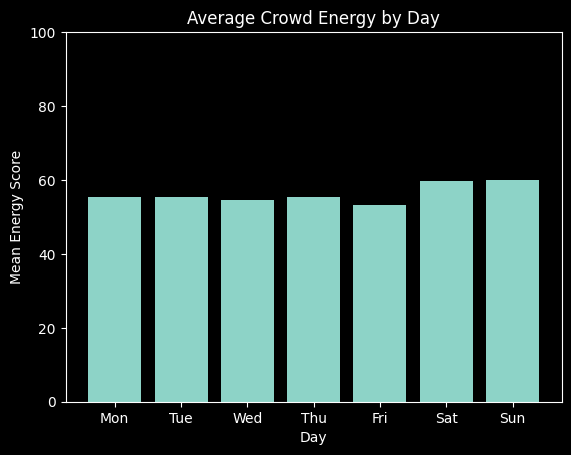

In [157]:
# Testing whether tuesdays affect our crowd_energy (or weekdays affect crowd energy)

# my choice = bar chart

X = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
Y = df.groupby('Day_of_Week')['Crowd_Energy'].mean().sort_index().values

plt.bar(X, Y)

plt.title('Average Crowd Energy by Day')
plt.ylabel('Mean Energy Score')
plt.xlabel('Day')
plt.ylim(0, 100)


plt.show()

**It is clearly seen that day of the week alone has nothing to do with the energy**
# therefore check the combination of weekday and the venue , if there is any trend present

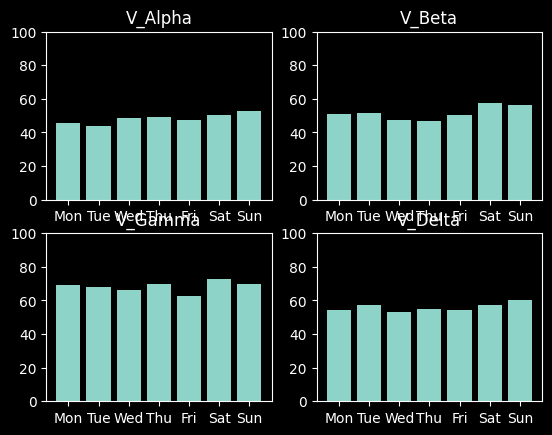

In [158]:
plt.subplot(2, 2, 1)
plt.title("V_Alpha")
Y = df[df["Venue_ID"] == "V_Alpha"].groupby("Day_of_Week")["Crowd_Energy"].mean().sort_index().values
plt.bar(X, Y)
plt.ylim((0, 100))

plt.subplot(2, 2, 2)
plt.title("V_Beta")
Y = df[df["Venue_ID"] == "V_Beta"].groupby("Day_of_Week")["Crowd_Energy"].mean().sort_index().values
plt.bar(X, Y)
plt.ylim((0, 100))

plt.subplot(2, 2, 3)
plt.title("V_Gamma")
Y = df[df["Venue_ID"] == "V_Gamma"].groupby("Day_of_Week")["Crowd_Energy"].mean().sort_index().values
plt.bar(X, Y)
plt.ylim((0, 100))

plt.subplot(2, 2, 4)
plt.title("V_Delta")
Y = df[df["Venue_ID"] == "V_Delta"].groupby("Day_of_Week")["Crowd_Energy"].mean().sort_index().values
plt.bar(X, Y)
plt.ylim((0, 100))


plt.show()


again no clear visible trend therefore drop the day of the week column as it is just noise we are feeding to our randomforest model which may result in detecting nonsence pateerns which do not exist

i think i should not drop it as there are little upward trends at weekends everywhere

**therefore all the singers assumpsum regarding Tuesdays or crowd_energy being dependent on weekdays is false**

# 2 Testing the theory about the monk venue 

find which venuw was the lead singer was referring to by plotting all the volume levels over all venues as singer mentioned somehting about noise limits

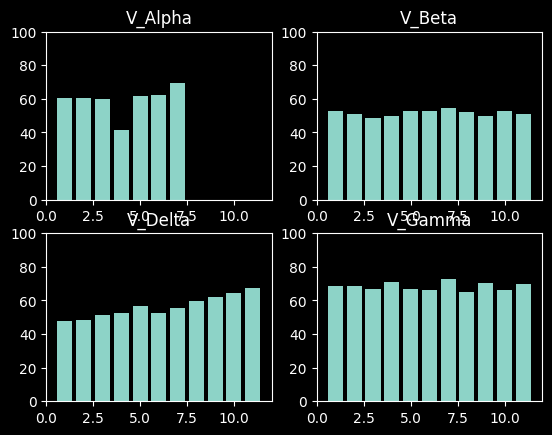

In [159]:
plt.subplot(2, 2, 1)

df_alpha = df[df['Venue_ID'] == 'V_Alpha']
alpha_means = df_alpha.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()

plt.bar(alpha_means.index, alpha_means.values)
plt.ylim(0, 100)
plt.xlim(0, 12)
plt.title('V_Alpha')



plt.subplot(2, 2, 2)

df_beta = df[df['Venue_ID'] == 'V_Beta']

beta_means = df_beta.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()
plt.bar(beta_means.index, beta_means.values)
plt.xlim(0, 12)
plt.ylim(0, 100)
plt.title('V_Beta')



plt.subplot(2, 2, 3)

df_delta = df[df['Venue_ID'] == 'V_Delta']

delta_means = df_delta.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()
plt.title('V_Delta')
plt.bar(delta_means.index, delta_means.values)
plt.xlim(0, 12)
plt.ylim(0, 100)



plt.subplot(2, 2, 4)
df_gamma = df[df['Venue_ID'] == 'V_Gamma']

gamma_means = df_gamma.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()

plt.bar(gamma_means.index, gamma_means.values)
plt.title('V_Gamma')
plt.ylim(0, 100)
plt.xlim(0, 12)

plt.show()

i think the monk theory is right , as in V_Alpha we see that there is actually a noise limit , noise doesn't go above 7.5 (with a single exception)

singer also mentioned an exceptional case where loud volume was allowed when crowd size is large

## Also the theory about singer that V_Delta , Loud = Bettwe is correct as evident from the above graph

let us test this theory by drawing graph of crowd size v/s volume v/s crowd energy using a filter

Text(0.5, 1.0, 'V_Alpha')

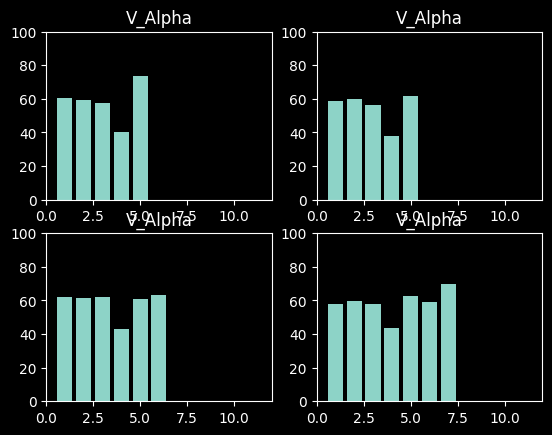

In [160]:
plt.subplot(2, 2, 1)
df_alpha = df[(df['Venue_ID'] == 'V_Alpha') & (df["Crowd_Size"] <= 250)]
alpha_means = df_alpha.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()

plt.bar(alpha_means.index, alpha_means.values)
plt.ylim(0, 100)
plt.xlim(0, 12)
plt.title('V_Alpha')

plt.subplot(2, 2, 2)
df_alpha = df[(df['Venue_ID'] == 'V_Alpha') & (df["Crowd_Size"] <= 500) & (df["Crowd_Size"] >= 250)]
alpha_means = df_alpha.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()

plt.bar(alpha_means.index, alpha_means.values)
plt.ylim(0, 100)
plt.xlim(0, 12)
plt.title('V_Alpha')

plt.subplot(2, 2, 3)
df_alpha = df[(df['Venue_ID'] == 'V_Alpha') & (df["Crowd_Size"] <= 750) & (df["Crowd_Size"] >= 500)]
alpha_means = df_alpha.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()

plt.bar(alpha_means.index, alpha_means.values)
plt.ylim(0, 100)
plt.xlim(0, 12)
plt.title('V_Alpha')


plt.subplot(2, 2, 4)
df_alpha = df[(df['Venue_ID'] == 'V_Alpha') & (df["Crowd_Size"] <= 1000) & (df["Crowd_Size"] >= 750)]
alpha_means = df_alpha.groupby('Volume_Level')['Crowd_Energy'].mean().sort_index()

plt.bar(alpha_means.index, alpha_means.values)
plt.ylim(0, 100)
plt.xlim(0, 12)
plt.title('V_Alpha')

It is seen that Singer was right , at low crowd sizes , top left the volume becomes low but at high crowd size , bottom right . the volume increases therefore the monk theory is correct !!

# 3 Testing the impact of hour (overall) and venue wise

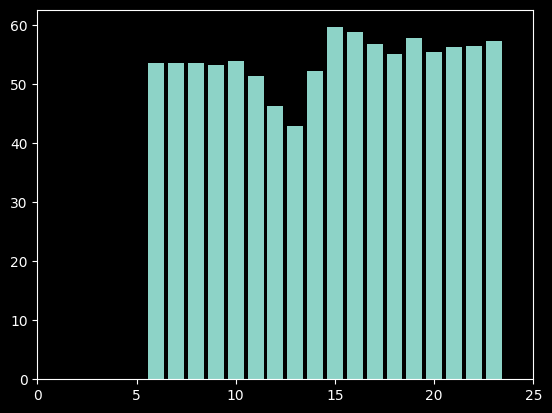

In [161]:
hours = df.groupby("Hour")["Crowd_Energy"].mean().sort_index()

plt.bar(hours.index, hours.values)
plt.xlim((0, 25))
plt.show()

late night or evenings are clearly better , i.e anything around after 2 pm is good

now let's see venue wise variation

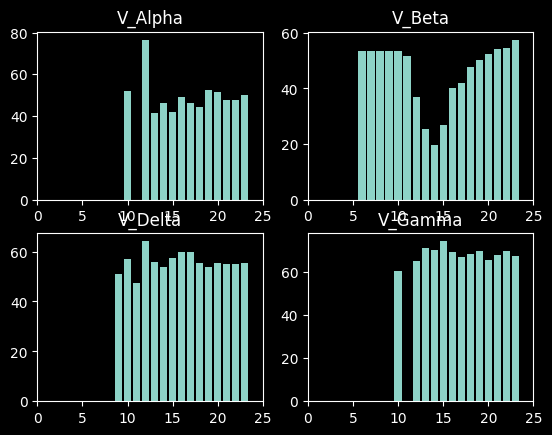

In [162]:
plt.subplot(2, 2, 1)

hours = df[df.Venue_ID == "V_Alpha"].groupby("Hour")["Crowd_Energy"].mean().sort_index()
plt.title("V_Alpha")
plt.bar(hours.index, hours.values)
plt.xlim((0, 25))

plt.subplot(2, 2, 2)

hours = df[df.Venue_ID == "V_Beta"].groupby("Hour")["Crowd_Energy"].mean().sort_index()

plt.title("V_Beta")
plt.bar(hours.index, hours.values)
plt.xlim((0, 25))


plt.subplot(2, 2, 3)

hours = df[df.Venue_ID == "V_Delta"].groupby("Hour")["Crowd_Energy"].mean().sort_index()

plt.title("V_Delta")
plt.bar(hours.index, hours.values)
plt.xlim((0, 25))


plt.subplot(2, 2, 4)

plt.title("V_Gamma")
hours = df[df.Venue_ID == "V_Gamma"].groupby("Hour")["Crowd_Energy"].mean().sort_index()

plt.bar(hours.index, hours.values)
plt.xlim((0, 25))

plt.show()

V_Beta shows very much variation and seems that night time is much better than day time , soo as per singer the "goth's" venue could be V_Beta

# 4 Moon Phase relation with crowd energy , (Venue wise) and overall

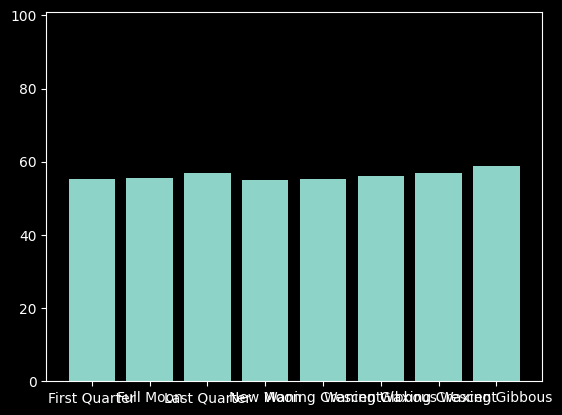

In [163]:
# Overall
moon = df.groupby("Moon_Phase")["Crowd_Energy"].mean().sort_index()
plt.bar(moon.index, moon.values)
plt.ylim((0, 101))

plt.show()

there is clearly no pattern here

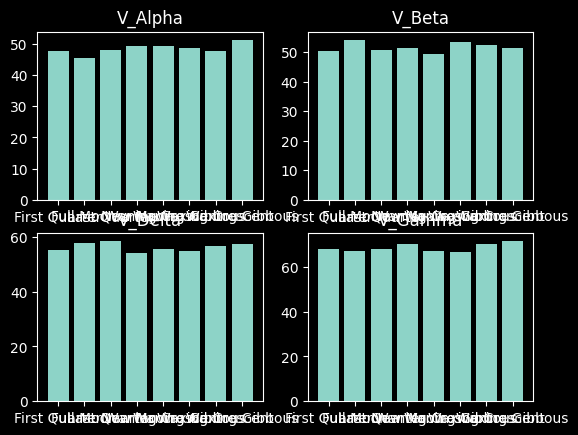

In [164]:
plt.subplot(2, 2, 1)

moon = df[df.Venue_ID == "V_Alpha"].groupby("Moon_Phase")["Crowd_Energy"].mean().sort_index()
plt.title("V_Alpha")
plt.bar(moon.index, moon.values)


plt.subplot(2, 2, 2)
moon = df[df.Venue_ID == "V_Beta"].groupby("Moon_Phase")["Crowd_Energy"].mean().sort_index()
plt.title("V_Beta")
plt.bar(moon.index, moon.values)



plt.subplot(2, 2, 3)
moon = df[df.Venue_ID == "V_Delta"].groupby("Moon_Phase")["Crowd_Energy"].mean().sort_index()
plt.title("V_Delta")
plt.bar(moon.index, moon.values)


plt.subplot(2, 2, 4)
moon = df[df.Venue_ID == "V_Gamma"].groupby("Moon_Phase")["Crowd_Energy"].mean().sort_index()
plt.title("V_Gamma")
plt.bar(moon.index, moon.values)


plt.show()

Here also i don't see any pattern , i decide to drop the moon column as it's just noise we are feeding to our data

therefore singer is wrong , moon does not matter

In [165]:
df.drop(columns=["Moon_Phase"], inplace=True)
df.columns

Index(['Gig_ID', 'Venue_ID', 'Day_of_Week', 'Volume_Level', 'Crowd_Size',
       'Opener_Rating', 'Weather', 'Band_Outfit', 'Crowd_Energy', 'Hour',
       'Month', 'Day_of_Month', 'Clean_Ticket_Price'],
      dtype='object')

# 5 Relation of outfit , along with venue and overall

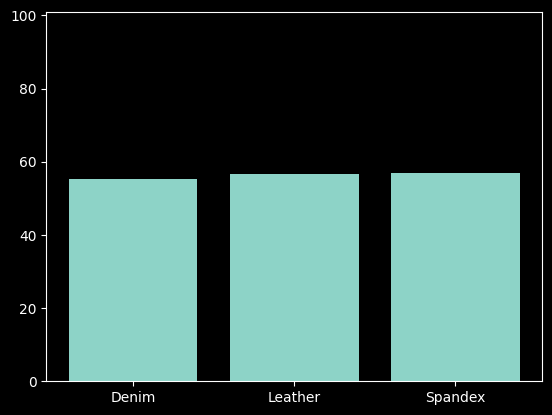

In [166]:
# Overall
outfit = df.groupby("Band_Outfit")["Crowd_Energy"].mean().sort_index()
plt.bar(outfit.index, outfit.values)
plt.ylim((0, 101))

plt.show()

THAT"s the flattest graph ive seen so far  haha , are they exactly same ???

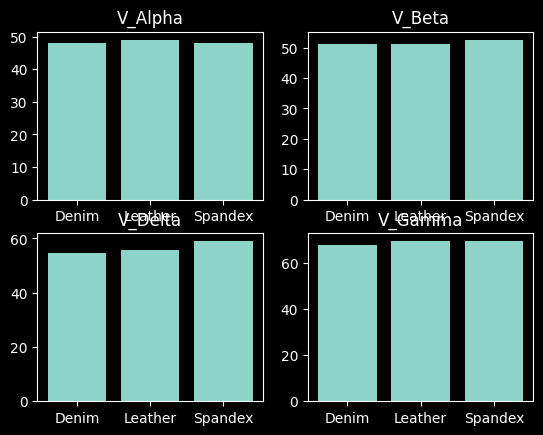

In [167]:
plt.subplot(2, 2, 1)

outfit = df[df.Venue_ID == "V_Alpha"].groupby("Band_Outfit")["Crowd_Energy"].mean().sort_index()
plt.title("V_Alpha")
plt.bar(outfit.index, outfit.values)


plt.subplot(2, 2, 2)
outfit = df[df.Venue_ID == "V_Beta"].groupby("Band_Outfit")["Crowd_Energy"].mean().sort_index()
plt.title("V_Beta")
plt.bar(outfit.index, outfit.values)



plt.subplot(2, 2, 3)
outfit = df[df.Venue_ID == "V_Delta"].groupby("Band_Outfit")["Crowd_Energy"].mean().sort_index()
plt.title("V_Delta")
plt.bar(outfit.index, outfit.values)


plt.subplot(2, 2, 4)
outfit = df[df.Venue_ID == "V_Gamma"].groupby("Band_Outfit")["Crowd_Energy"].mean().sort_index()
plt.title("V_Gamma")
plt.bar(outfit.index, outfit.values)


plt.show()

This is also flat , i am dropping the outift column , as outfit does not matter , singer is wrong again , the socks do not matter

In [168]:
df.drop(columns=["Band_Outfit"], inplace=True)

# 6 Testing : weather variation with venue

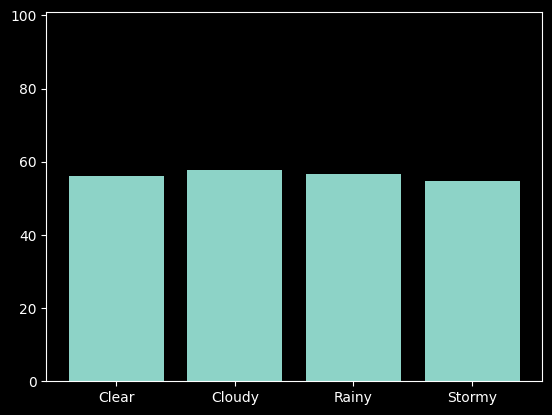

In [169]:
# Overall
weather = df.groupby("Weather")["Crowd_Energy"].mean().sort_index()
plt.bar(weather.index, weather.values)
plt.ylim((0, 101))

plt.show()

flat again

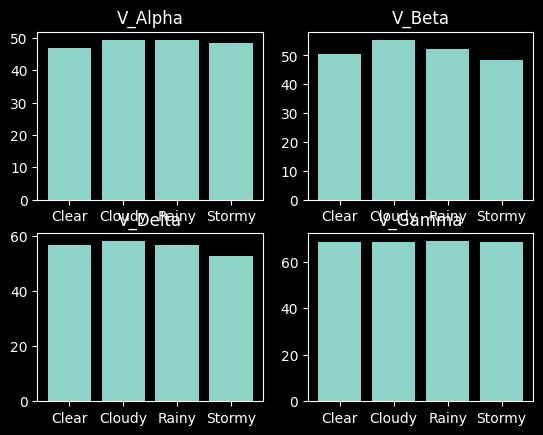

In [170]:
plt.subplot(2, 2, 1)

weather = df[df.Venue_ID == "V_Alpha"].groupby("Weather")["Crowd_Energy"].mean().sort_index()
plt.title("V_Alpha")
plt.bar(weather.index, weather.values)


plt.subplot(2, 2, 2)
weather = df[df.Venue_ID == "V_Beta"].groupby("Weather")["Crowd_Energy"].mean().sort_index()
plt.title("V_Beta")
plt.bar(weather.index, weather.values)



plt.subplot(2, 2, 3)
weather = df[df.Venue_ID == "V_Delta"].groupby("Weather")["Crowd_Energy"].mean().sort_index()
plt.title("V_Delta")
plt.bar(weather.index, weather.values)


plt.subplot(2, 2, 4)
weather = df[df.Venue_ID == "V_Gamma"].groupby("Weather")["Crowd_Energy"].mean().sort_index()
plt.title("V_Gamma")
plt.bar(weather.index, weather.values)


plt.show()

it seems that stormy wheather affets V_Delta andV_Beta

# 6 Testing : Ticket pricing vs Venue vs Energy

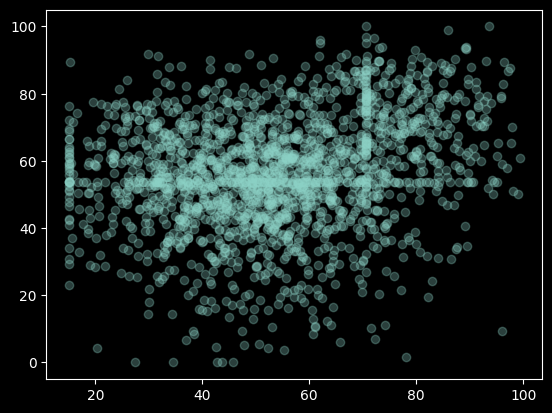

In [171]:
plt.scatter(df["Clean_Ticket_Price"], df["Crowd_Energy"], alpha=0.3)
plt.show()

nothing clearly visible , let's see venue vise

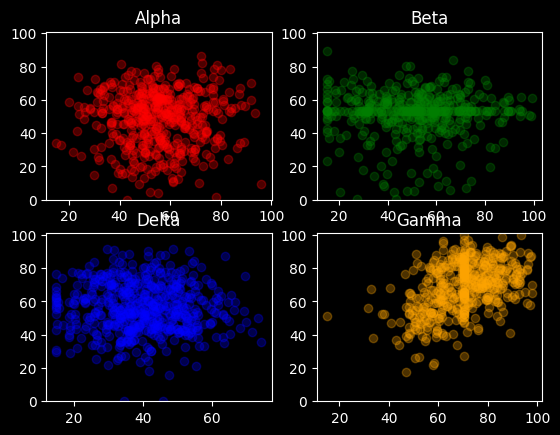

In [172]:
plt.subplot(2, 2, 1)
plt.scatter(df[df.Venue_ID == "V_Alpha"]["Clean_Ticket_Price"], df[df.Venue_ID == "V_Alpha"]["Crowd_Energy"], alpha=0.3, c="red")
plt.ylim((0, 101))
plt.title("Alpha")


plt.subplot(2, 2, 2)
plt.scatter(df[df.Venue_ID == "V_Beta"]["Clean_Ticket_Price"], df[df.Venue_ID == "V_Beta"]["Crowd_Energy"], alpha=0.3, c="green")
plt.ylim((0, 101))
plt.title("Beta")


plt.subplot(2, 2, 3)
plt.scatter(df[df.Venue_ID == "V_Delta"]["Clean_Ticket_Price"], df[df.Venue_ID == "V_Delta"]["Crowd_Energy"], alpha=0.3, c="blue")
plt.ylim((0, 101))
plt.title("Delta")


plt.subplot(2, 2, 4)
plt.scatter(df[df.Venue_ID == "V_Gamma"]["Clean_Ticket_Price"], df[df.Venue_ID == "V_Gamma"]["Crowd_Energy"], alpha=0.3, c="orange")
plt.ylim((0, 101))
plt.title("Gamma")
plt.show()



A trend is visible in V_Gamma , where increasing the pricing increased the energy , and very few came where the prices were too low , 

however for other venuws anything beween 30 to 70 dollars worked fine

therefore V_Gamma has PRICE sentitivity as hinted by the singer

`IMPORTANT` : lokking carefully at V_Beta here are a lot of records with 0 crowd energy(now they are shifted to median), which is clearly a glitch in data collection , i think i should fix that with the median values 

(This is the explanatin i was reffering to earliner in crowd_Energy data filtering)

# 7 Opener vs venue 

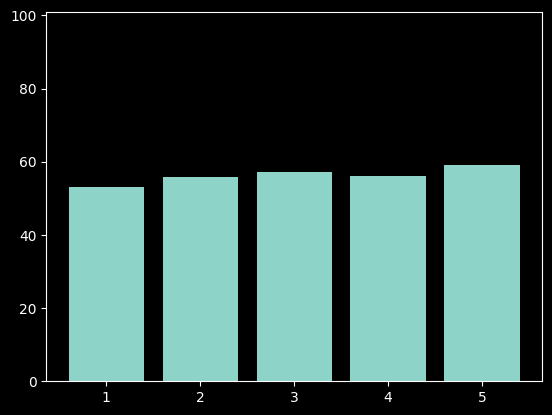

In [173]:
opner = df.groupby("Opener_Rating")["Crowd_Energy"].mean().sort_index()

plt.bar(opner.index, opner.values)
plt.ylim((0, 101))

plt.show()

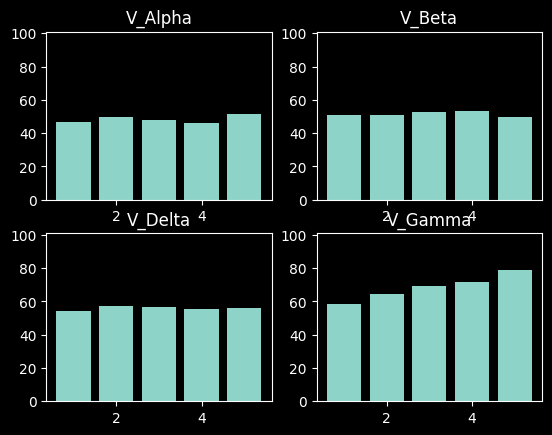

In [174]:
plt.subplot(2, 2, 1)
opner = df[df.Venue_ID == "V_Alpha"].groupby("Opener_Rating")["Crowd_Energy"].mean().sort_index()

plt.title("V_Alpha")
plt.bar(opner.index, opner.values)
plt.ylim((0, 101))

plt.subplot(2, 2, 2)
opner = df[df.Venue_ID == "V_Beta"].groupby("Opener_Rating")["Crowd_Energy"].mean().sort_index()

plt.title("V_Beta")
plt.bar(opner.index, opner.values)
plt.ylim((0, 101))

plt.subplot(2, 2, 3)
opner = df[df.Venue_ID == "V_Delta"].groupby("Opener_Rating")["Crowd_Energy"].mean().sort_index()

plt.title("V_Delta")
plt.bar(opner.index, opner.values)
plt.ylim((0, 101))

plt.subplot(2, 2, 4)
opner = df[df.Venue_ID == "V_Gamma"].groupby("Opener_Rating")["Crowd_Energy"].mean().sort_index()

plt.title("V_Gamma")
plt.bar(opner.index, opner.values)
plt.ylim((0, 101))

plt.show()

Looks like V_Gamma (Snobs) care about the opener and V_Delta(Most Pit) does not , yes the opener matters for V_Gamma , therefore we will NOT drop this column

In [175]:
df.Clean_Ticket_Price.describe()

count    1949.000000
mean       53.695162
std        18.443158
min        15.000000
25%        40.380000
50%        53.187600
75%        67.754500
max        99.320000
Name: Clean_Ticket_Price, dtype: float64

# 8 Crowd_Size , Venue interrelation

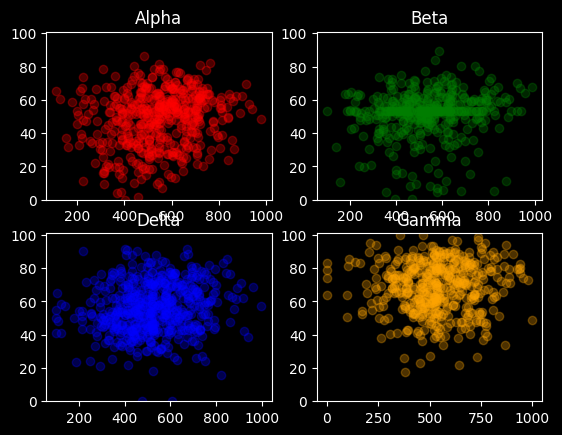

In [176]:
plt.subplot(2, 2, 1)
plt.scatter(df[df.Venue_ID == "V_Alpha"]["Crowd_Size"], df[df.Venue_ID == "V_Alpha"]["Crowd_Energy"], alpha=0.3, c="red")
plt.ylim((0, 101))
plt.title("Alpha")


plt.subplot(2, 2, 2)
plt.scatter(df[df.Venue_ID == "V_Beta"]["Crowd_Size"], df[df.Venue_ID == "V_Beta"]["Crowd_Energy"], alpha=0.3, c="green")
plt.ylim((0, 101))
plt.title("Beta")


plt.subplot(2, 2, 3)
plt.scatter(df[df.Venue_ID == "V_Delta"]["Crowd_Size"], df[df.Venue_ID == "V_Delta"]["Crowd_Energy"], alpha=0.3, c="blue")
plt.ylim((0, 101))
plt.title("Delta")


plt.subplot(2, 2, 4)
plt.scatter(df[df.Venue_ID == "V_Gamma"]["Crowd_Size"], df[df.Venue_ID == "V_Gamma"]["Crowd_Energy"], alpha=0.3, c="orange")
plt.ylim((0, 101))
plt.title("Gamma")
plt.show()



the above scater plot is messy to understand , let's group the data in slots and draw the bar graph of the mean in those slots

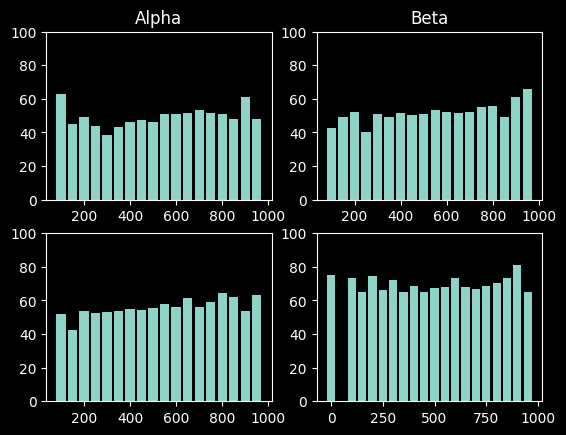

In [177]:
df['discreet'] = (df['Crowd_Size'] // 50) * 50



plt.subplot(2, 2, 1)
d1 = df[df.Venue_ID == "V_Alpha"].groupby("discreet")["Crowd_Energy"].mean()

plt.bar(d1.index, d1.values, width=40)
plt.title("Alpha")
plt.ylim(0, 100)


plt.subplot(2, 2, 2)
d1 = df[df.Venue_ID == "V_Beta"].groupby("discreet")["Crowd_Energy"].mean()
plt.bar(d1.index, d1.values, width=40)
plt.title("Beta")
plt.ylim(0, 100)


plt.subplot(2, 2, 3)
d1 = df[df.Venue_ID == "V_Delta"].groupby("discreet")["Crowd_Energy"].mean()
plt.bar(d1.index, d1.values, width=40)
plt.ylim(0, 100)


plt.subplot(2, 2, 4)
d1 = df[df.Venue_ID == "V_Gamma"].groupby("discreet")["Crowd_Energy"].mean()
plt.bar(d1.index, d1.values, width=40)
plt.ylim(0, 100)


plt.show()

df.drop(columns=["discreet"], inplace=True)

as we can see that there is somewhat variation for V_Delta(bottom left) as crowd increases , the size also increaes , therefore we keep the column

The singer was right about V_Delta being better when ("Packeed") and when loud , and found above

## DONE with visual EDA  

---------------------------------------------------------------------

# TESTING NEW FEATURES , (Feature engineering)
`DayOfMonth`
`Month` 

In [178]:
df.columns

Index(['Gig_ID', 'Venue_ID', 'Day_of_Week', 'Volume_Level', 'Crowd_Size',
       'Opener_Rating', 'Weather', 'Crowd_Energy', 'Hour', 'Month',
       'Day_of_Month', 'Clean_Ticket_Price'],
      dtype='object')

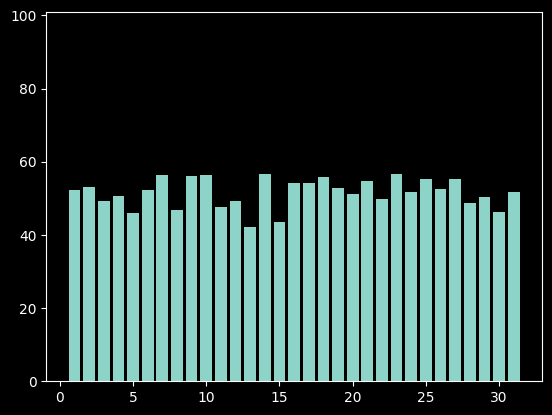

In [179]:
# here i played wth Day_Of_month and Venues , and see that most of the times the graph has 
# low-high-low features , which i believe would be covered by Day_Of_Week
monthday = df[df.Venue_ID == "V_Beta"].groupby("Day_of_Month")["Crowd_Energy"].mean().sort_index()

plt.bar(monthday.index, monthday.values)
plt.ylim((0, 101))

plt.show()

i decide to drop this column

In [180]:
df.drop(columns=["Day_of_Month"], inplace=True)

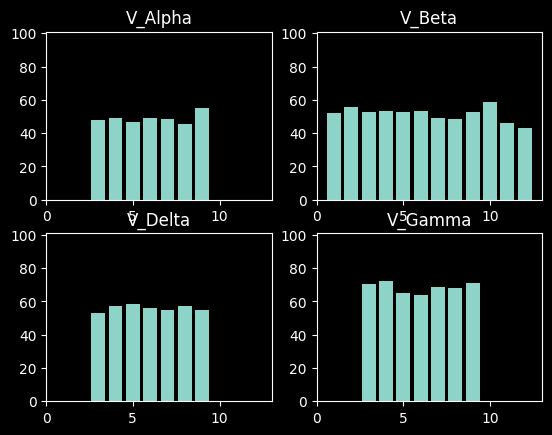

In [181]:
# now by month
plt.subplot(2, 2, 1)
month = df[df.Venue_ID == "V_Alpha"].groupby("Month")["Crowd_Energy"].mean().sort_index()
plt.bar(month.index, month.values)
plt.title("V_Alpha")
plt.xlim((0, 13))
plt.ylim((0, 101))

plt.subplot(2, 2, 2)
month = df[df.Venue_ID == "V_Beta"].groupby("Month")["Crowd_Energy"].mean().sort_index()
plt.bar(month.index, month.values)
plt.title("V_Beta")
plt.xlim((0, 13))
plt.ylim((0, 101))

plt.subplot(2, 2, 3)
month = df[df.Venue_ID == "V_Delta"].groupby("Month")["Crowd_Energy"].mean().sort_index()
plt.bar(month.index, month.values)
plt.title("V_Delta")
plt.xlim((0, 13))
plt.ylim((0, 101))

plt.subplot(2, 2, 4)
month = df[df.Venue_ID == "V_Gamma"].groupby("Month")["Crowd_Energy"].mean().sort_index()
plt.bar(month.index, month.values)
plt.title("V_Gamma")
plt.xlim((0, 13))
plt.ylim((0, 101))


plt.show()

There is a Pattern!

Except V_Beta all the venues have good response when shows are between March to October , 

therefore we design a new Feature , i.e "Good_Month" which is true only when month is not V_Beta and Month is not between [March,October]

In [182]:
df["Good_Month"] = (((df["Month"] < 3) | (df.Month > 10)) & (df.Venue_ID != "V_Beta")).astype(int)
df.Good_Month

0       0
1       0
2       0
3       0
4       0
       ..
1993    0
1994    0
1995    0
1996    0
1999    0
Name: Good_Month, Length: 1949, dtype: int64

We can drop the old Month Column as it does not have any other pattern which is not covered by our Good_Month feature

In [183]:
df.drop(columns=["Month"], inplace=True)

`Late night` it was visible above that  at V_Beta (gothic nightclib) turns fire at night ( around 7PM i.e 19) , this parameter will capture it

0       1
1       1
2       0
3       1
4       0
       ..
1993    1
1994    1
1995    1
1996    1
1999    1
Name: Late_night, Length: 1949, dtype: int64


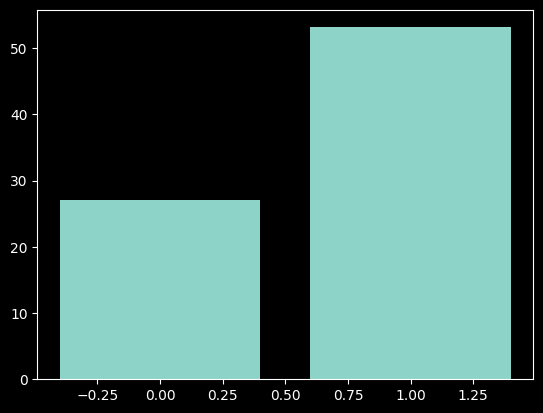

In [184]:
df['Late_night'] = (((df["Hour"] <= 12) & (df["Hour"] >= 5)) | (df["Hour"] >= 18)).astype(int)
late = df[df.Venue_ID == "V_Beta"].groupby("Late_night")["Crowd_Energy"].mean().sort_index()
print(df["Late_night"])

# Verification
plt.bar(late.index, late.values)
plt.show()

`Monk_status` as we must know when Monk can and cannot control the concert in V_Alpha , which depends on the crowd size , my guess would be around 600 since it is after 500 before 750 and closer to 500

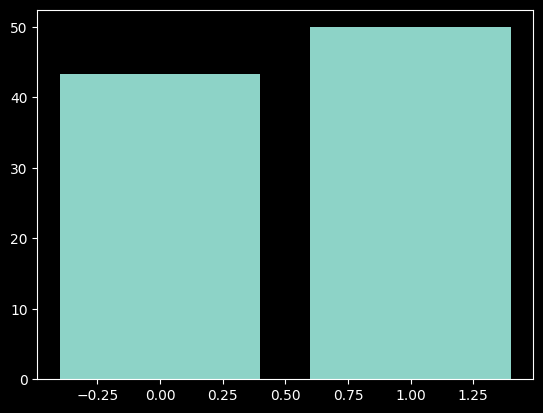

In [185]:
df["Monk_status"] = (df["Crowd_Size"] >= 425).astype(int)

#Verification
monk = df[df.Venue_ID == "V_Alpha"].groupby("Monk_status")["Crowd_Energy"].mean().sort_index()

plt.bar(monk.index, monk.values)
plt.show()

## DONE with Feature Engineering

-------------------------------------------------------------------------

# DEVELOPING a RandomForest Based Model

since we saw that there are hidden features which a simple multi-variable regressor would miss , as it would't see many factors venue wise

and since RandomForest model is the only one in the resources which i think is right
i already clarified why not use multi variable regressor , since it will miss the exceptional Monk think , also it will also miss the V_Gamma Price sensitivity as , since for other venue it deoes not matter it will overweight the V_Gamma effect

moreover RandomFOrest model would create a root note / closer to root node , a node of Venue as since most of our things are based of Venue

In [186]:
df.drop(columns=["Gig_ID"], inplace=True)
df.rename(columns={"Clean_Ticket_Price": "Ticket_Price"}, inplace=True)
df.columns

Index(['Venue_ID', 'Day_of_Week', 'Volume_Level', 'Crowd_Size',
       'Opener_Rating', 'Weather', 'Crowd_Energy', 'Hour', 'Ticket_Price',
       'Good_Month', 'Late_night', 'Monk_status'],
      dtype='object')

In [ ]:
# Encode the Venue feature 
df_copy_before = df.copy() # for future use
df = pd.get_dummies(df, columns=['Venue_ID', 'Weather'], drop_first=True)
df = df[sorted(df.columns)] # Reorder alphabeically so that test and train columns match directly
df_copy_after = df.drop(columns=['Crowd_Energy']).copy() # for future use

X = df.drop(columns=['Crowd_Energy'])
Y = df['Crowd_Energy']

print(X)
print(Y)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=4)

without_hypertuning = RandomForestRegressor(random_state=4)
without_hypertuning.fit(X_train, y_train)


y_pred = without_hypertuning.predict(X_val)


rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(rmse)

      Crowd_Size  Day_of_Week  Good_Month  Hour  Late_night  Monk_status  \
0          464.0            3           0  21.0           1            1   
1          388.0            3           0  22.0           1            0   
2          679.0            5           0  15.0           0            1   
3          454.0            0           0   8.0           1            1   
4          654.0            4           0  17.0           0            1   
...          ...          ...         ...   ...         ...          ...   
1993       323.0            0           0  23.0           1            0   
1994       432.0            6           0  20.0           1            1   
1995       699.0            6           0  20.0           1            1   
1996       588.0            3           0  23.0           1            1   
1999       744.0            2           0  19.0           1            1   

      Opener_Rating  Ticket_Price  Venue_ID_V_Beta  Venue_ID_V_Delta  \
0              

Therefore here we are getting RMSE of 14 which is not bad as averagely our predictions vary by around 14% of the actual value

**Now we do it using hypertuning**

we can check for different hyperparameters like number of trees in our forest , the depth of each tree , and also the minimum number of columns our model selects at each iteration of building a tree

luckly this process of finding and selecting can be automated using GridSerch CV , 

we call the model using GridSearch CV, with a object as parameter which contains arryas of the values we want to test

and set the error evealuation method i.e root mean squared error , 


here's what it does 
it splits data into `cv` parts and trains the model on `cv - 1` parts and tests on the remaining part , for each combination of parameters , ensuring randomness and avoiding the question(what if i just get lucky? at the test sub-dataset)

In [ ]:



testing = {
# i will keep trees less since it is taking soo much time
# to train
    # number of trees in forest
    'n_estimators': [ 80, 100, 150, 200], 
    # see while random selection what is the minimum value we want
    'min_samples_split': [10, 15, 20, 25, 30], 
    # see how much brenches we need
    'max_depth': [5, 10, 15, 20, 25]
}

# this below code was taking a long time soo i googled up that n_jobs thing

# gridsearch will check ever possible combination of these three, utilising all the cores of my laptop (i.e n_jobs= -1)
grid_search = GridSearchCV(RandomForestRegressor(random_state= 7 ), testing, cv= 5 , scoring = 'neg_root_mean_squared_error' , n_jobs = -1)
grid_search.fit(X_train, y_train)


print(grid_search.best_params_)
print(grid_search.best_score_)

d:\AI-ML\CC task ML module\MlTaskLibraries\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 150}
-12.854026467243623


earlier we got 14 this time we got 12.85 , thats a slight tuning we got now let's train the complete model based on all the rows

In [ ]:
complete_model = RandomForestRegressor(
    random_state=4
    # these are the setings hypertuing gave us
    max_depth=10, 
    min_samples_split=30, 
    n_estimators=150, 
)

complete_model.fit(X, Y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",150
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",30
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples

# Now taking the results for the final test set (which was untouched till now)

In [190]:
test = pd.read_csv("tour_logs_test_input.csv")
print(test.columns)
print(test.describe())
print(test.isna().sum())

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show'],
      dtype='object')
       Day_of_Week  Volume_Level   Crowd_Size  Opener_Rating  \
count   500.000000    458.000000   489.000000     500.000000   
mean      3.128000      5.179039   536.243354       2.968000   
std       2.047437      3.299532   176.347064       1.393866   
min       0.000000     -5.000000     0.000000       1.000000   
25%       1.000000      2.000000   419.000000       2.000000   
50%       3.000000      5.000000   529.000000       3.000000   
75%       5.000000      8.000000   652.000000       4.000000   
max       6.000000     11.000000  1101.000000       5.000000   

       Merch_Sales_Post_Show  
count              500.00000  
mean               693.41200  
std                397.83363  
min                  0.00000  
25%                421.75000  
50%        

In [191]:
# Do filtering and FIlling of the missing data in the Testing dataset

# we will need the Gig_ID row later
Gig_ID = test["Gig_ID"]
# delete not required columns
test.drop(columns=["Merch_Sales_Post_Show", "Moon_Phase", "Band_Outfit", "Gig_ID"], inplace=True)

 Extract the Hour from Show_DateTime and where hour is not found
 we will replace that value with the median of the Show_Hour at that Venue we got in our "Train" dataset

In [192]:
# This code is copy paste from above


# first let's see how many distict patters are there in our dataset
def identifying_patterns(date):
    date = str(date)
    # now to identify pattern of that date we replace all the numbers with 0 and all the letters with A
    pattern = re.sub(r"\d", '0', re.sub(r"[a-zA-Z]", "A", date))
    # the third argument above retuns all lettrs replased with A and the outside fuction returns all numbers replaced with 0 
    return pattern

# apply the above function to datetime colum and see the results
result = test["Show_DateTime"].apply(identifying_patterns)

print(test.groupby(result)["Show_DateTime"].first())
print("\n")
print(test.groupby(result).size())

Show_DateTime
00-00-0000 00:00          06-16-2024 19:00
00/00/0000 00:00 AA    11/04/2024 07:00 AM
0000-00-00 00:00:00    2024-05-08 16:00:00
AAA 00, 0000                  May 31, 2024
AAAA 00, 0000                July 29, 2024
AAAA AAAAA                      Late Night
AAAAA 00, 0000              March 06, 2024
AAAAAA 00, 0000            August 03, 2024
AAAAAAA                            Evening
AAAAAAAAA                        Afternoon
AAAAAAAAA 00, 0000      September 04, 2024
Name: Show_DateTime, dtype: object


Show_DateTime
00-00-0000 00:00        31
00/00/0000 00:00 AA     30
0000-00-00 00:00:00    399
AAA 00, 0000             2
AAAA 00, 0000            7
AAAA AAAAA               5
AAAAA 00, 0000           6
AAAAAA 00, 0000          5
AAAAAAA                  9
AAAAAAAAA                1
AAAAAAAAA 00, 0000       5
dtype: int64


In [193]:
test["Show_DateTime"] = pd.to_datetime(test["Show_DateTime"], format="mixed", errors="coerce")

test.Show_DateTime.isna().sum()

np.int64(15)

therefore 15 values could not be parsed , replace them with their venue median

In [194]:
test["Hour"] = test["Show_DateTime"].dt.hour
test["Month"] = test["Show_DateTime"].dt.month
test[["Hour", "Month"]].isna().sum()

Hour     15
Month    15
dtype: int64

In [195]:
test.loc[(test.Venue_ID == "V_Alpha") & (test.Hour.isna()), "Hour"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Alpha", "Hour"].median()
)

test.loc[(test.Venue_ID == "V_Beta") & (test.Hour.isna()), "Hour"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Beta", "Hour"].median()
)

test.loc[(test.Venue_ID == "V_Gamma") & (test.Hour.isna()), "Hour"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Gamma", "Hour"].median()
)

test.loc[(test.Venue_ID == "V_Delta") & (test.Hour.isna()), "Hour"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Delta", "Hour"].median()
)

test["Hour"].isna().sum()
test.drop(columns=["Show_DateTime"], inplace=True)

In [196]:
test.isna().sum()

Venue_ID          0
Day_of_Week       0
Volume_Level     42
Ticket_Price      0
Crowd_Size       11
Opener_Rating     0
Weather           0
Hour              0
Month            15
dtype: int64

Replace NaN Month values with `July` , as it is the median month across
all venues , below is a graph attached from above which makes it
clear of why i choose July

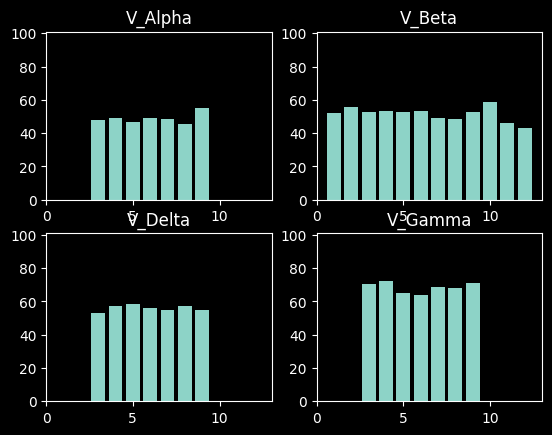

In [197]:
test.loc[test.Month.isna(), "Month"] = 7
test["Month"].isna().sum()

np.int64(0)

Now , we convert the Month column to our New feature (Good_Month)

In [198]:
test["Good_Month"] = (((test["Month"] < 3) | (test.Month > 10)) & (test.Venue_ID != "V_Beta")).astype(int)
test.Good_Month.isna().sum()

np.int64(0)

Finally drop the non-needed month column

In [199]:
test.drop(columns=["Month"], inplace=True)

Adjust the volume levels

In [200]:

good = df_copy_before[(df_copy_before["Volume_Level"] >= 1) & (df_copy_before["Volume_Level"] <= 11)]
medians = good.groupby("Venue_ID")["Volume_Level"].median()

bad = (test["Volume_Level"] <= 0) | (test["Volume_Level"] > 11) | (test["Volume_Level"].isna())

test.loc[bad, "Volume_Level"] = test.loc[bad, "Venue_ID"].map(medians)


print(test.isna().sum())

Venue_ID          0
Day_of_Week       0
Volume_Level      0
Ticket_Price      0
Crowd_Size       11
Opener_Rating     0
Weather           0
Hour              0
Good_Month        0
dtype: int64


Handle the Crowd_Size 

In [201]:
test.loc[(test.Crowd_Size <= 0) | (test.Crowd_Size > 1000), "Crowd_Size"] = np.nan
test.isna().sum()

Venue_ID          0
Day_of_Week       0
Volume_Level      0
Ticket_Price      0
Crowd_Size       20
Opener_Rating     0
Weather           0
Hour              0
Good_Month        0
dtype: int64

now replace the nan values with the average of respective vanue

In [202]:
test.loc[(test.Venue_ID == "V_Alpha") & (test.Crowd_Size.isna()), "Crowd_Size"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Alpha", "Crowd_Size"].median()
)

test.loc[(test.Venue_ID == "V_Beta") & (test.Crowd_Size.isna()), "Crowd_Size"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Beta", "Crowd_Size"].median()
)

test.loc[(test.Venue_ID == "V_Gamma") & (test.Crowd_Size.isna()), "Crowd_Size"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Gamma", "Crowd_Size"].median()
)

test.loc[(test.Venue_ID == "V_Delta") & (test.Crowd_Size.isna()), "Crowd_Size"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Delta", "Crowd_Size"].median()
)

test["Crowd_Size"].isna().sum()


np.int64(0)

now handle the ticket prices in different units

In [203]:
test.Ticket_Price.describe()

test.Ticket_Price = test.Ticket_Price.apply(convert_usd)

test.Ticket_Price.isna().sum()

np.int64(16)

handle the nan ticket prices based of their venues meadians

In [204]:
test.loc[(test.Venue_ID == "V_Alpha") & (test.Ticket_Price.isna()), "Ticket_Price"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Alpha", "Ticket_Price"].median()
)

test.loc[(test.Venue_ID == "V_Beta") & (test.Ticket_Price.isna()), "Ticket_Price"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Beta", "Ticket_Price"].median()
)

test.loc[(test.Venue_ID == "V_Gamma") & (test.Ticket_Price.isna()), "Ticket_Price"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Gamma", "Ticket_Price"].median()
)

test.loc[(test.Venue_ID == "V_Delta") & (test.Ticket_Price.isna()), "Ticket_Price"] = (
    df_copy_before.loc[df_copy_before.Venue_ID == "V_Delta", "Ticket_Price"].median()
)

test["Ticket_Price"].isna().sum()


np.int64(0)

In [205]:
test.isna().sum()
test.head(10)

,Venue_ID,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Hour,Good_Month
0,V_Alpha,2,2.0,69.96,747.0,4,Cloudy,16.0,0
1,V_Alpha,6,4.0,44.82,541.0,5,Cloudy,16.0,0
2,V_Alpha,2,3.0,40.96,636.0,3,Cloudy,22.0,0
3,V_Beta,3,1.0,50.70,655.0,4,Clear,7.0,0
4,V_Delta,0,1.0,15.61,587.0,3,Stormy,17.0,0
5,V_Alpha,1,2.0,73.58,547.0,2,Rainy,23.0,0
6,V_Alpha,1,4.0,74.01,338.0,5,Stormy,22.0,0
7,V_Alpha,4,5.0,70.18,382.0,3,Stormy,18.0,0
8,V_Beta,5,11.0,91.74,387.0,5,Cloudy,0.0,0
9,V_Alpha,0,4.0,64.63,496.0,5,Stormy,18.0,0


In [206]:
# Built the custom parameters i.e Feature Engineering
test["Monk_status"] = (test["Crowd_Size"] >= 425).astype(int)

test['Late_night'] = (((test["Hour"] <= 12) & (test["Hour"] >= 5)) | (test["Hour"] >= 18)).astype(int)

# We are now ready to predict the values based of our model

In [207]:
test = pd.get_dummies(test, columns=['Venue_ID', 'Weather'], drop_first=True)
test = test[sorted(test.columns)]
test.head(10)

,Crowd_Size,Day_of_Week,Good_Month,Hour,Late_night,Monk_status,Opener_Rating,Ticket_Price,Venue_ID_V_Beta,Venue_ID_V_Delta,Venue_ID_V_Gamma,Volume_Level,Weather_Cloudy,Weather_Rainy,Weather_Stormy
0,747.0,2,0,16.0,0,1,4,69.96,False,False,False,2.0,True,False,False
1,541.0,6,0,16.0,0,1,5,44.82,False,False,False,4.0,True,False,False
2,636.0,2,0,22.0,1,1,3,40.96,False,False,False,3.0,True,False,False
3,655.0,3,0,7.0,1,1,4,50.70,True,False,False,1.0,False,False,False
4,587.0,0,0,17.0,0,1,3,15.61,False,True,False,1.0,False,False,True
5,547.0,1,0,23.0,1,1,2,73.58,False,False,False,2.0,False,True,False
6,338.0,1,0,22.0,1,0,5,74.01,False,False,False,4.0,False,False,True
7,382.0,4,0,18.0,1,0,3,70.18,False,False,False,5.0,False,False,True
8,387.0,5,0,0.0,0,0,5,91.74,True,False,False,11.0,True,False,False
9,496.0,0,0,18.0,1,1,5,64.63,False,False,False,4.0,False,False,True


In [208]:
print(df_copy_after.columns)
print(test.columns)
test

Index(['Crowd_Size', 'Day_of_Week', 'Good_Month', 'Hour', 'Late_night',
       'Monk_status', 'Opener_Rating', 'Ticket_Price', 'Venue_ID_V_Beta',
       'Venue_ID_V_Delta', 'Venue_ID_V_Gamma', 'Volume_Level',
       'Weather_Cloudy', 'Weather_Rainy', 'Weather_Stormy'],
      dtype='object')
Index(['Crowd_Size', 'Day_of_Week', 'Good_Month', 'Hour', 'Late_night',
       'Monk_status', 'Opener_Rating', 'Ticket_Price', 'Venue_ID_V_Beta',
       'Venue_ID_V_Delta', 'Venue_ID_V_Gamma', 'Volume_Level',
       'Weather_Cloudy', 'Weather_Rainy', 'Weather_Stormy'],
      dtype='object')


,Crowd_Size,Day_of_Week,Good_Month,Hour,Late_night,Monk_status,Opener_Rating,Ticket_Price,Venue_ID_V_Beta,Venue_ID_V_Delta,Venue_ID_V_Gamma,Volume_Level,Weather_Cloudy,Weather_Rainy,Weather_Stormy
0,747.0,2,0,16.0,0,1,4,69.96,False,False,False,2.0,True,False,False
1,541.0,6,0,16.0,0,1,5,44.82,False,False,False,4.0,True,False,False
2,636.0,2,0,22.0,1,1,3,40.96,False,False,False,3.0,True,False,False
3,655.0,3,0,7.0,1,1,4,50.70,True,False,False,1.0,False,False,False
4,587.0,0,0,17.0,0,1,3,15.61,False,True,False,1.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,456.0,6,0,10.0,1,1,4,33.33,True,False,False,2.0,False,True,False
496,480.0,4,0,18.0,1,1,4,28.25,False,True,False,9.0,False,False,False
497,707.0,4,0,16.0,0,1,3,40.87,False,False,False,2.0,True,False,False
498,481.0,4,0,21.0,1,1,2,22.29,False,True,False,3.0,False,False,True


In [209]:
# great now everything is aligned and we can output our predictions

# ensure same columns 
print(test.columns)
print(X.columns)

Index(['Crowd_Size', 'Day_of_Week', 'Good_Month', 'Hour', 'Late_night',
       'Monk_status', 'Opener_Rating', 'Ticket_Price', 'Venue_ID_V_Beta',
       'Venue_ID_V_Delta', 'Venue_ID_V_Gamma', 'Volume_Level',
       'Weather_Cloudy', 'Weather_Rainy', 'Weather_Stormy'],
      dtype='object')
Index(['Crowd_Size', 'Day_of_Week', 'Good_Month', 'Hour', 'Late_night',
       'Monk_status', 'Opener_Rating', 'Ticket_Price', 'Venue_ID_V_Beta',
       'Venue_ID_V_Delta', 'Venue_ID_V_Gamma', 'Volume_Level',
       'Weather_Cloudy', 'Weather_Rainy', 'Weather_Stormy'],
      dtype='object')


In [218]:
# GENERATE FINAL PRDEICTIONS
final_prediction = complete_model.predict(test) 

answer = pd.DataFrame({
    "Gig_ID" : Gig_ID, # we saved this before
    "Crowd_Energy" : final_prediction
})

answer.to_csv("predictions(actual).csv", index=False)

# BonuS Task finding ticket price fo each venue

In [211]:
df_copy_Bonus.drop(columns=['Gig_ID'], inplace=True)
df_copy_Bonus

,Venue_ID,Day_of_Week,Volume_Level,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,Hour,Month,Day_of_Month,Clean_Ticket_Price
0,V_Alpha,3,5.0,464.0,2,Rainy,Waning Crescent,Leather,64.96,21.0,3.0,7.0,52.93
1,V_Beta,3,2.0,388.0,5,Clear,New Moon,Leather,66.42,22.0,9.0,5.0,66.33
2,V_Delta,5,1.0,679.0,1,Rainy,Waning Crescent,Denim,42.58,15.0,3.0,9.0,51.37
3,V_Beta,0,10.0,454.0,1,Rainy,New Moon,Leather,53.60,8.0,8.0,7.0,64.77
4,V_Delta,4,8.0,654.0,5,Cloudy,Full Moon,Spandex,67.55,17.0,4.0,26.0,47.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,V_Beta,0,7.0,323.0,3,Clear,New Moon,Denim,58.87,23.0,10.0,6.0,55.01
1994,V_Beta,6,4.0,432.0,4,Cloudy,Waxing Gibbous,Denim,61.32,20.0,8.0,18.0,62.86
1995,V_Alpha,6,4.0,699.0,5,Stormy,First Quarter,Denim,40.67,20.0,6.0,16.0,57.34
1996,V_Beta,3,7.0,588.0,5,Stormy,Full Moon,Spandex,65.60,23.0,5.0,23.0,26.94


my intuition would be to plot the ticket price vs the amount of people arrived at each venue 

Singer's managers notes mention about ticket price for each venue 

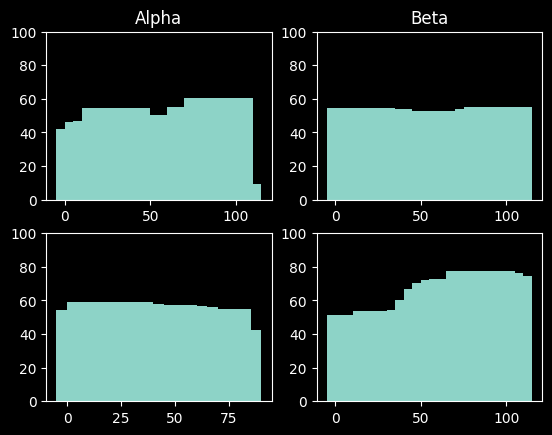

In [212]:
df_copy_Bonus['discreet'] = (df_copy_Bonus['Clean_Ticket_Price'] // 5) * 5



plt.subplot(2, 2, 1)
d1 = df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Alpha"].groupby("discreet")["Crowd_Energy"].mean()

plt.bar(d1.index, d1.values, width=40)
plt.title("Alpha")
plt.ylim(0, 100)


plt.subplot(2, 2, 2)
d1 = df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Beta"].groupby("discreet")["Crowd_Energy"].mean()
plt.bar(d1.index, d1.values, width=40)
plt.title("Beta")
plt.ylim(0, 100)


plt.subplot(2, 2, 3)
d1 = df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Delta"].groupby("discreet")["Crowd_Energy"].mean()
plt.bar(d1.index, d1.values, width=40)
plt.ylim(0, 100)


plt.subplot(2, 2, 4)
d1 = df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Gamma"].groupby("discreet")["Crowd_Energy"].mean()
plt.bar(d1.index, d1.values, width=40)
plt.ylim(0, 100)


plt.show()

df_copy_Bonus.drop(columns=["discreet"], inplace=True)

therefore for V_Gamma higher ticket prices are working better

singer also mentioned about relation of crowd-Energy with merch sales 

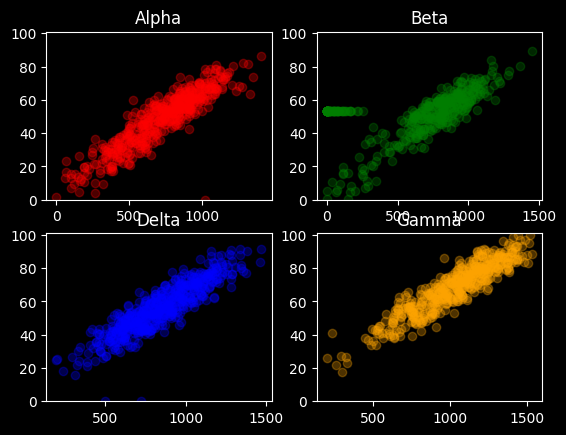

In [213]:
df_copy_Bonus["Merch_Sales_Post_Show"] = merch

plt.subplot(2, 2, 1)
plt.scatter(df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Alpha"]["Merch_Sales_Post_Show"], df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Alpha"]["Crowd_Energy"], alpha=0.3, c="red")
plt.ylim((0, 101))
plt.title("Alpha")


plt.subplot(2, 2, 2)
plt.scatter(df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Beta"]["Merch_Sales_Post_Show"], df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Beta"]["Crowd_Energy"], alpha=0.3, c="green")
plt.ylim((0, 101))
plt.title("Beta")


plt.subplot(2, 2, 3)
plt.scatter(df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Delta"]["Merch_Sales_Post_Show"], df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Delta"]["Crowd_Energy"], alpha=0.3, c="blue")
plt.ylim((0, 101))
plt.title("Delta")


plt.subplot(2, 2, 4)
plt.scatter(df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Gamma"]["Merch_Sales_Post_Show"], df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Gamma"]["Crowd_Energy"], alpha=0.3, c="orange")
plt.ylim((0, 101))
plt.title("Gamma")
plt.show()



The singer was correct "Low energy" = "Low revenue"

also let me plot the merch sales per venue

<BarContainer object of 4 artists>

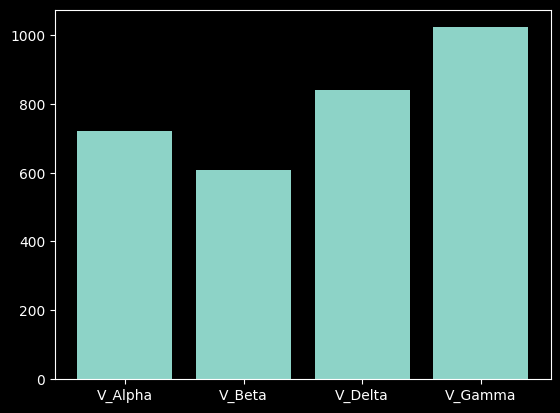

In [214]:
merch = df_copy_Bonus.groupby("Venue_ID")["Merch_Sales_Post_Show"].mean().sort_index()
plt.bar(merch.index, merch.values)

# My conclusion (non-formula based) instead trend based

V_Gamma = Keep ticket prices high , around 80-90 $ since , it has higher crowd when ticket prices are high , maximisig profit

V_Delta = 40-60 $ since crowd's reaction is same for almost all types of prices except the extremea and we don't have to set the price too high , as we are already making good amout with the merch

V_Alpha = 50-70 $ since crowd's reaction is same for almost all types of prices except the extreme, and we have to cover for the less merch sales in Alpha comared to Delta and Gamma

V_Beta = 70-80 $ again to cover up the merch sales


# Formula derivation , for profit

1) `Revenue` generated

it is clear that revenue = Ticket_Price * Crowd_Size + Merch_Sales_Post_Show

2.`Cost` required by the band 

Cost = $5000 (fixed per show) + $8 * Crowd_Size

3. Breaking down the Merch_Sales_Post_Show parameter

earlier we say that it changes linearly with energy , which is evident form 
above graph , which i will copy paste below

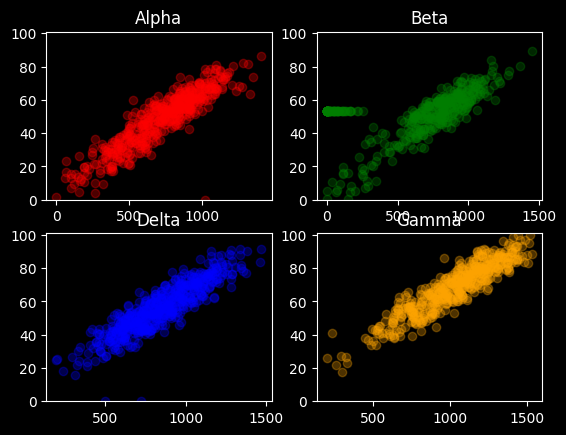

In [215]:
# Let's get the linear relationship between them by simple linear regression
# for each venue
X = df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Alpha"]["Crowd_Energy"].values.reshape(-1, 1)
Y = df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Alpha"]["Merch_Sales_Post_Show"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

print(linear.score(X_test, y_test))
m = linear.coef_[0]
c = linear.intercept_
print(m)
print(c)

0.8740548354305379
14.208929657734288
32.99534508724139


Results :

**V_Alpha => merch = 14.2 * energy + 32.99**

**V_Delta => merch = 13.58 * energy + 78.53**

**v_Gamma => merch = 15.68 * energy - 58.04**


for V_Beta the R2 score was 0.2 which says that is it not linear

Therefore we can change the merch_sales variable with these , and just take median merch sales for V_Beta

In [216]:
merch_Beta = df_copy_Bonus[df_copy_Bonus.Venue_ID == "V_Beta"]["Merch_Sales_Post_Show"].mean()
merch_Beta

np.float64(608.4954545454545)

for V_beta , it is = 608.49 dollars